In [1]:
using DataFrames, PyPlot, ScikitLearn


In [2]:
Pkg.checkout("LowRankModels")


Symbol) in module Base at loading.jl:345 overwritten in module Main at C:\Users\User\.julia\v0.5\Requires\src\require.jl:12.
INFO: Checking out LowRankModels master...
INFO: Pulling LowRankModels latest master...
INFO: No packages to install, update or remove


In [3]:
using LowRankModels
include("proxgrad.jl");

# Question 1

In [4]:
cancer = readtable("breast-cancer.csv", header=false)
head(cancer)
@show size(cancer)

size(cancer) = (683,10)


(683,10)

In [5]:
X = [ones(size(cancer)[1]) array(copy(cancer[2:end]))] # added offset. ends at col 10
y = array(cancer[1])
@show size(X)
w = X\y
@show w;

 in depwarn(::String, ::Symbol) at .\deprecated.jl:64
 in array(::DataFrames.DataFrame) at .\deprecated.jl:50
 in include_string(::String, ::String) at .\loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\User\.julia\v0.5\IJulia\src\execute_request.jl:169
 in eventloop(::ZMQ.Socket) at C:\Users\User\.julia\v0.5\IJulia\src\eventloop.jl:8
 in (::IJulia.##9#15)() at .\task.jl:360
while loading In[5], in expression starting on line 1


size(X) = (683,10)


Use convert(Array, da).
 in depwarn(::String, ::Symbol) at .\deprecated.jl:64
 in array(::DataArrays.DataArray{Int64,1}) at C:\Users\User\.julia\v0.5\DataArrays\src\deprecated.jl:23
 in include_string(::String, ::String) at .\loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\User\.julia\v0.5\IJulia\src\execute_request.jl:169
 in eventloop(::ZMQ.Socket) at C:\Users\User\.julia\v0.5\IJulia\src\eventloop.jl:8
 in (::IJulia.##9#15)() at .\task.jl:360
while loading In[5], in expression starting on line 2


w = [-1.49532,0.0634262,0.04369,0.0312793,0.0164865,0.0201502,0.0907726,0.0383512,0.0370587,0.00195777]


c) Split into training and test set. Run your prox grad method on the TRAINING SET to get w_hinge and w_logistic.

In [6]:
#srand(2)
shuffle_arr = shuffle(collect(1:683))

train_array = zeros(342)
test_array = zeros(341)

train_array[1:342] = shuffle_arr[1:342]

test_array[1:341] =  shuffle_arr[343:683]

train = zeros(342,10)
test= zeros(341,10);

In [7]:
# training X
for i in 1:342
    for j in 1:10
       train[i,j]= X[convert(Int64, train_array[i]),j] 
    end
end

# testing X
for i in 1:size(test)[1]
    for j in 1:size(X)[2]
        test[i,j]= X[convert(Int64, test_array[i]),j]
    end
end

In [8]:
# training y 
y_train = zeros(342)

for i in 1:342
    y_train[i]= y[convert(Int, train_array[i])]
end
y_train = convert(DataArray{Int64,1}, y_train);

# test y 
y_test = zeros(341)

for i in 1:341
    y_test[i] = y[convert(Int, test_array[i])]
end
y_test = convert(DataArray{Int64,1}, y_test);

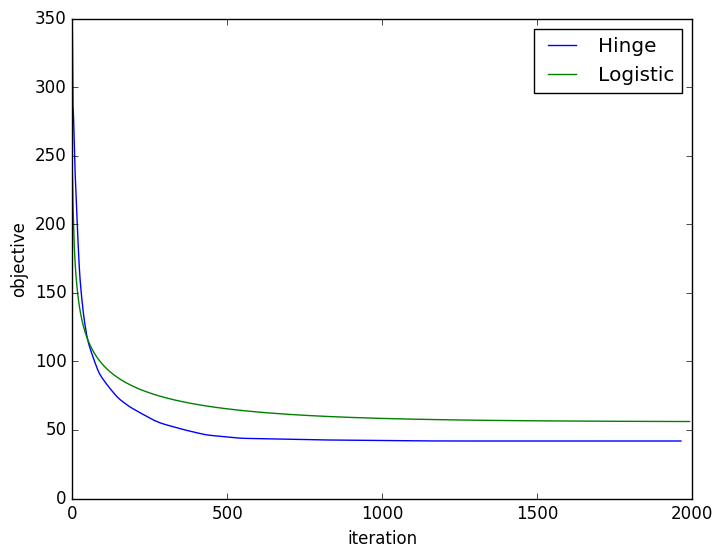

w_hinge = [-1.40705,-0.0682421,0.354603,0.0928735,0.0018713,-0.27802,0.253076,-0.0788006,0.148246,0.0709429]
w_logistic = [-3.73348,-0.0200419,0.454606,0.221722,0.0266541,-0.458006,0.452328,-0.0159388,0.295468,0.197465]


In [9]:
# using functions from Julia package
ch1 = ConvergenceHistory("Hinge")
ch2 = ConvergenceHistory("Logistic")

w_hinge = proxgrad(HingeLoss(), QuadReg(1), train, y_train, stepsize = 0.1, maxiters = 2000, ch = ch1) 
w_logistic = proxgrad(LogisticLoss(), QuadReg(1), train, y_train, stepsize = 0.1, maxiters = 2000, ch = ch2)

plot(ch1.objective, label = "Hinge")
plot(ch2.objective, label = "Logistic")
xlabel("iteration")
ylabel("objective")
legend()

@show w_hinge
@show w_logistic;

Least squares no regulariser
10-element Array{Float64,1}:

 -1.49532   
  0.0634262 
  0.04369   
  0.0312793 
  0.0164865 
  0.0201502 
  0.0907726 
  0.0383512 
  0.0370587 
  0.00195777

d) Misclassification rate

In [10]:
 #type : data array
check_hinge = (y_test.==sign(test*w_hinge))
check_logistic = (y_test.==sign(test*w_logistic));

In [11]:
# converts true to 1 and false to 0
check_hinge = convert(Array{Int}, check_hinge)
check_logistic = convert(Array{Int}, check_logistic)
misclass_hinge =  1- mean(check_hinge)
misclass_logistic = 1-mean(check_logistic)
@show misclass_hinge
@show misclass_logistic

misclass_hinge = 0.058651026392961825
misclass_logistic = 0.05278592375366564


0.05278592375366564

On the TEST set, the logistic model and the hinge model has similar error rates.

e) Why is there no normalizing constant for logistic loss?

Because P_logistic is the value of logistic(yw^Tx), and the logistic function ranges from 0 to 1, which the probability range should be in. Thus there is no need to scale the logistic loss to get a probability.

f) Compute log-likelihood.

In [50]:
loss_logistic = LogisticLoss()
predicted_logistic = test*w_logistic

# using for loop
llh_logistic = 0
for i in 1:size(test)[1]
    llh_logistic -= evaluate(loss_logistic, predicted_logistic[i], y_test[i])
end

# using one step
loglikelihood_logistic = -evaluate(loss_logistic, test*w_logistic, y_test)

### HINGE ###

loss_hinge = HingeLoss()

predicted_hinge = test*w_hinge
p_hinge= zeros(size(test)[1])
loglikelihood_hinge=0

for i in 1:size(test)[1]
    numerator = exp(-evaluate(loss_hinge, predicted_hinge[i], y_test[i]))
    denominator = exp(-evaluate(loss_hinge, predicted_hinge[i],1)) + exp(-evaluate(loss_hinge, predicted_hinge[i], -1))
    p_hinge[i] = numerator/denominator
    loglikelihood_hinge += log(p_hinge[i])
end


@show llh_logistic
@show loglikelihood_logistic

@show loglikelihood_hinge


llh_logistic = -54.828575455394784
loglikelihood_logistic = -54.828575455394784
loglikelihood_hinge = -68.58533625718258


-68.58533625718258

The loglikelihood of the logistic is larger.


# Question 2

# Question 3

In [14]:
birth = readtable("birthSample.txt", separator = '\t')

,MaritalStatus,PrenatalCare,Male,Weight
1,0,1,0,3326
2,1,0,0,1340
3,0,0,0,3033
4,1,1,1,3884
5,0,0,0,3108
6,1,1,1,3912
7,1,1,1,2546
8,1,1,1,4545
9,0,1,0,3402
10,1,1,1,3884


# a) Fit an ordinary least squares regression to the data. Interpret the coefficients that you find

In [15]:
X = array(birth[:, [:MaritalStatus, :PrenatalCare, :Male]])
nrows = size(X)[1]
X = [ones(nrows) copy(X)]
X
y = array(birth[:, :Weight])
w = X\y


4-element Array{Float64,1}:
 3138.93  
  101.362 
   73.0585
  124.357 

All of the factors (Marital status, prenatal care, male) are positively correlated with birth weight, which makes sense intuitively. Male has the highest weight, followed by marital status and prenatal care.

# b) Fit a quantile regression on the data with $q=0.05$ and $q=0.95$. Compare these coefficients to those you found in part a).



In [16]:
proxgrad(QuantileLoss(quantile = 0.05 ), ZeroReg(), X, y, maxiters=1000)


4-element Array{Float64,1}:
 2154.25
  227.0 
  133.75
   52.0 

In [17]:
proxgrad(QuantileLoss(quantile = 0.95 ), ZeroReg(), X, y, maxiters=1000)

4-element Array{Float64,1}:
 3932.3   
   82.3661
   67.3379
  198.743 

Answers from part a: 

3138.93
101.362 
73.0585
124.357 

Similarities: Male has the highest weight, followed by marital status and prenatal care
Differences: Male and marital status have a highe r weight on low weight babies than high weight babies. Prenatal care has a lower weight on low weight babies than high weight babies.



# c) Fit quantile regressions for $q=0.05, 0.10, \cdots, 0.95$.

In [18]:
weights = []
for q in 0.05:0.05:0.95
    push!(weights, proxgrad(QuantileLoss(quantile = q), ZeroReg(), X, y, maxiters=1000))
end

In [19]:
weights2 = zeros(19,4)
for i in 1:19
    weights2[i,1:4] = weights[i]
end
weights2

19×4 Array{Float64,2}:
 2154.25  227.0     133.75     52.0   
 2498.13  138.87     84.999    86.8779
 2646.9   114.447    87.8784   98.778 
 2760.63  102.5      74.3733  102.374 
 2851.02  101.109    77.875    98.9844
 2921.13   86.1503   81.2596  114.464 
 2992.62   86.884    67.494   114.666 
 3054.2    91.8262   63.666   120.312 
 3108.23   95.7653   61.7653  125.366 
 3151.68   91.5527   73.7676  137.893 
 3235.37   89.2868   45.3404  133.34  
 3284.48   88.3657   66.7571  132.398 
 3348.32   88.4261   63.2571  132.426 
 3418.71   84.0      57.2891  137.375 
 3483.13   81.6035   61.4629  144.807 
 3555.55   85.7531   67.9039  146.798 
 3629.2    77.4346   84.0867  150.279 
 3743.25   89.7637   78.9863  165.932 
 3932.3    82.3661   67.3379  198.743 

# d) Create an intercept plot that plots quantiles against the intercept coefficient from that quantile regression. Create coefficient plots for MaritalStatus, Male, and PrenatalCare coefficients.


The coefficients for intercept, marital status and prenatal care increase as the quantile increases. The coefficient for male decreases as the quantile increases.

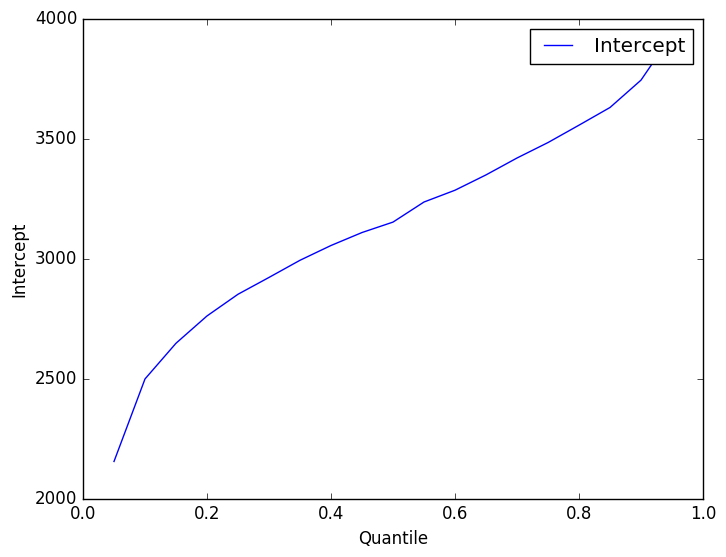

In [20]:
plot(0.05:0.05:0.95, weights2[1:19,1], label = "Intercept")

xlabel("Quantile")
ylabel("Intercept")
legend();

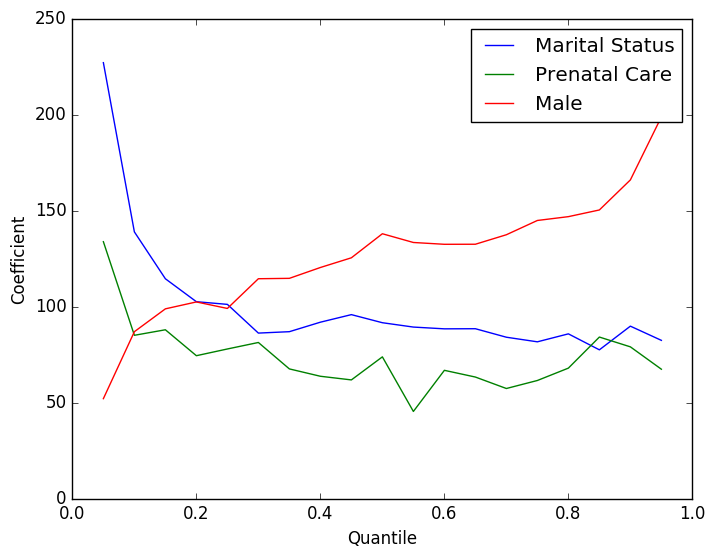

In [21]:
plot(0.05:0.05:0.95, weights2[1:19,2], label = "Marital Status")
plot(0.05:0.05:0.95, weights2[1:19,3], label = "Prenatal Care")
plot(0.05:0.05:0.95, weights2[1:19,4], label = "Male")

xlabel("Quantile")
ylabel("Coefficient")
legend();

# e) How should you interpret the intercepts of the quantile regressions?

The intercept is the weight when marital status = 0, prenatal care = 0, male = 0

# f) What does the coefficient plot tell you about the effect of prenatal care for infants with low birth weight compared to those with average birth weights?

The effect of prenatal care for infants with low birth weights is higher than those with average birth weights. 